In [62]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #03 - Statistical Objective Analysis

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using statistical objective analysis.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [63]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [64]:
### Read in observations ###
directory = "/Users/techadmin/ATMO528/ATSC528/"
filename = "RAOBs_201903131200.txt"
data_str = np.loadtxt("RAOBs_201903131200.txt", delimiter = ',', dtype = str)
# file = open(directory + filename)
# data = file.read()
latitude = data_str[:, 1].astype(float)
longitude = data_str[:, 2].astype(float)
g_h = data_str[:, 3].astype(float)
print(g_h.shape)

#print(latitude)

(135,)


In [65]:
### Set up analysis map with a 22x28 rectangular grid of points ###
phi0 = np.radians(60) #phi naught , 60N
psi0 = np.radians(90)-phi0
lambda0 = -115 #lamda naught, 115W
delx = 1.27 #cm
dely = 1.27 #cm
x0 = 18.90 #cm
y0 = -6.30 #cm 
x_range = np.arange(22)
y_range = np.arange(28)
#print(x_range)
x_calculation = x0 + (delx*x_range) 
y_calculation = y0 + (dely*y_range)
rho = 6371000 #meters
map_scale = 1/15000000 #15 million

x = np.array(x_calculation)
y = np.array(y_calculation)
x_g, y_g = np.meshgrid(x,y)
#print(x_g.shape) 

In [66]:
### convert obs lat/long to x,y ###
x_g_m = x_g/100
y_g_m = y_g/100
print(x_g_m.shape)
numer = (((((x_g_m)/map_scale)**2)+(((y_g_m)/map_scale)**2))**(1/2))
denom = rho*(1+(np.cos(psi0)))
psi = (np.pi/2) - (2*(np.arctan(numer/denom))) #x-cord, y-cord to latitude?
psi = np.degrees(psi)

lamda = (np.degrees(np.arctan(y_g_m/x_g_m)))+lambda0 #x-cord, y-cord to longitude?
# print(lamda)

# print(psi,lamda)
# plt.imshow(lamda)
# plt.colorbar()

(28, 22)


In [67]:
###Making background field
sigma = ((1+np.sin(np.radians(60)))/(1+np.sin(np.radians(latitude))))

x_ob = rho*sigma*(np.cos(np.radians(latitude)))*(np.cos(np.radians(longitude)+np.radians(115))) #converting coords to x
y_ob = rho*sigma*(np.cos(np.radians(latitude)))*(np.sin(np.radians(longitude)+np.radians(115))) #converting coords to y
# print(y_ob.shape)
x_ob = x_ob * map_scale *100 #now in cm
y_ob = y_ob * map_scale *100
x_ob_cm = x_ob
y_ob_cm = y_ob
# x_ob = x_ob/100
# y_ob = y_ob/100
# print('x_ob', x_ob)
# print('y_ob', y_ob)

for i in range(len(x_ob)):
      # distance_analysis_to_ob = np.sqrt(((x_g_m[i,j]-x_ob)**2)+((y_g_m[i,j]-y_ob)**2))
      distance_ob_to_ob = np.sqrt(((x_ob[i]-x_ob)**2)+((y_ob[i]-y_ob)**2))
      # print("with zero =",len(distance_ob_to_ob))
      distance_ob_to_ob = np.delete(distance_ob_to_ob,i)
      #distance_ob_to_ob = distance_ob_to_ob[distance_ob_to_ob>1e-10] #------------told in class that dmin = avg minimum distance between obs.
      # print("without zero =",len(distance_ob_to_ob))
      #print('distance_ob_to_ob', distance_ob_to_ob)
      #print('distance_ob_to_ob_shape', distance_ob_to_ob.min())

x_g_cm = x_g_m*100
y_g_cm = y_g_m*100
Kd = 10.8844524 #cm**2
re = 12.7775892 #cm
fb = np.zeros((28,22))
w = []
for i in range(len(x_g_cm)):
    for j in range(len(x_g_cm[i])):
              distance_analysis_to_ob = np.sqrt(((x_g_cm[i,j]-x_ob)**2)+((y_g_cm[i,j]-y_ob)**2))
              dik = distance_analysis_to_ob[distance_analysis_to_ob !=0]
              #dik = dik[dik>R1]
              #print('dik**2',dik**2)
              #w.append(cressman(R1, dik))
              w = np.exp((-dik**2)/Kd)
              #print('w', w)
              #print('w shape', w.shape)
              fb[i,j] = (np.nansum(w*g_h)/np.nansum(w))
              
# print('w', w)
print('w shape', w.shape)
# print('fb', fb)
print('fb shape', fb.shape)


w shape (135,)
fb shape (28, 22)


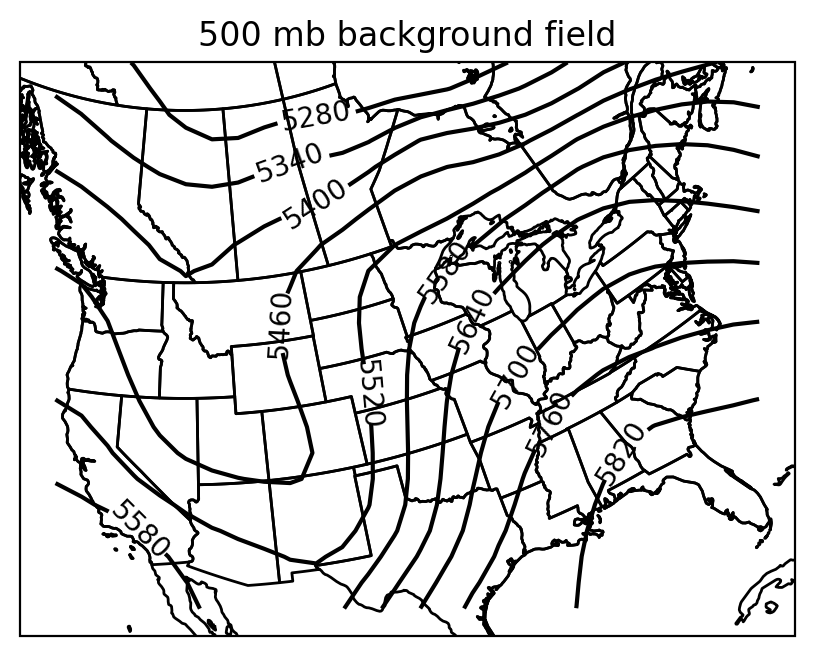

In [68]:
### First analysis, no successive corrections ###
# analysis_1 = np.sum(w*dik*g_h)/(np.sum(w*dik))
# print(analysis_1)

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(5,5),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,fb,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("500 mb background field")
plt.show()

In [72]:
### Analysis
print(distance_ob_to_ob.shape)
distance_ob_to_ob = distance_ob_to_ob.reshape(28, 22)
print(distance_ob_to_ob.shape)
#rho_obs_matrix = 

# s = d*(100)
# rho_s = 0.95*np.exp(-1.24*(s**2)) #Schlatter 1975 

# rho_kl = ?
# rho_ik = np.nansum(w*rho_kl) #w needs to be 

#Perform 3 analyses using
N = 2 #(use the 2 closest stations) 
N = 4 #(use the 4 closest stations) 
N = 10 #(use the 10 closest stations)

# fa = np.zeros((28,22))
# fa[i,j] = fb + (np.nansum(w*(g_h - fb))) #not sure if this is right - w should be w_ik not w(d_ik), Analysis equation
# plt.contour(fa)

(134,)


ValueError: cannot reshape array of size 134 into shape (28,22)

In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    

3 - What happens as you increase the number of points considered for the analysis?  Is this 
    desirable?  Why or why not?
    
'''

'\n1 - Describe the general features that you see in your contoured analyses.\n    \n\n2 - Describe the differences that you see in your contoured analyses.  \n    Does one analysis seem to be smoother than the other?  If so, what would cause this?\n    \n\n3 - What happens as you increase the number of points considered for the analysis?  Is this \n    desirable?  Why or why not?\n    \n'